# Store Item Demand Forecasting Challenge

https://www.kaggle.com/c/demand-forecasting-kernels-only/notebooks

### The objective of this competition is to predict 3 months of item-level sales data at different store locations.

PRÓXIMOS PASSOS:

- Usar o test.csv
- Usar day of week
- Usar week of year
- Usar mean of group, ex: data_df['itemweekday_mean'] = data_df.groupby(['weekday', 'item'])['sales'].transform('mean')
data_df['storeweekday_mean'] = data_df.groupby(['weekday', 'store'])['sales'].transform('mean')
data_df['storeitemweekday_mean'] = data_df.groupby(['weekday', 'item', 'store'])['sales'].transform('mean')



- Aprender Time Series, técnicas como ARIMA, pra utilizar de modo correto

# 0.0 Imports & Setup

## 0.1 Imports and Global Settings

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import matplotlib.gridspec as gridspec
import xgboost as xgb
import random
import pickle
import requests
import dill
#import warnings

#warnings.filterwarnings( 'ignore' )

from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.display import Image
from scipy import stats
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

In [2]:
np.random.seed(0)

## 0.2 Helper Functions

In [3]:
# Cramer com correção de Bias
def cramer_v(x, y):
    
    tc = pd.crosstab(x, y).values
    n = tc.sum()
    r, k = tc.shape
    
    chi2 = stats.chi2_contingency(tc)[0]
    chi2_corrigido = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    k_corrigido = k - (k-1) **2 / (n-1)
    r_corrigido = r - (r-1) **2 / (n-1)
    
    return np.sqrt( chi2_corrigido/n / (min(k_corrigido-1, r_corrigido-1)))


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


# prediction timeframe in days
def time_series_cross_validation( x_time_series, kfold, pred_timeframe, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    time_block = ( x_time_series['date'].max() - x_time_series['date'].min() - datetime.timedelta( days=pred_timeframe ) ) / kfold
    start_date = x_time_series['date'].min()
    for k in range(1, kfold+1):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # end date for training
        end_date = start_date + time_block * k
        
        # filtering dataset
        train = x_time_series[x_time_series['date'] <= end_date]
        validation = x_time_series[x_time_series['date'] > end_date]
        
        x_train = train.drop( ['date', 'sales'], axis=1 )
        y_train = train['sales']
        
        x_validation = validation.drop( ['date', 'sales'], axis=1 )
        y_validation = validation['sales']
        
        # fitting
        m = model.fit( x_train, y_train  )
        
        # prediction
        yhat = m.predict( x_validation )
        
        # performance
        m_result = ml_error( model_name,  y_validation ,  yhat )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )                


# prediction timeframe in days
def log_time_series_cross_validation( x_time_series, kfold, pred_timeframe, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    time_block = ( x_time_series['date'].max() - x_time_series['date'].min() - datetime.timedelta( days=pred_timeframe ) ) / kfold
    start_date = x_time_series['date'].min()
    for k in range(1, kfold+1):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # end date for training
        end_date = start_date + time_block * k
        
        # filtering dataset
        train = x_time_series[x_time_series['date'] <= end_date]
        validation = x_time_series[x_time_series['date'] > end_date]
        
        x_train = train.drop( ['date', 'sales'], axis=1 )
        y_train = train['sales']
        
        x_validation = validation.drop( ['date', 'sales'], axis=1 )
        y_validation = validation['sales']
        
        # fitting
        m = model.fit( x_train, y_train  )
        
        # prediction
        yhat = m.predict( x_validation )
        
        # performance
        m_result = ml_error( model_name,  np.expm1(y_validation) ,  np.expm1(yhat) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )   

    
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*3*30)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*3*30)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance *** USING EXPONENTIAL BECAUSE THE RESPONSE VARIABLE WAS TRANSFORMED BY LOG !!!
        m_result = ml_error( model_name, ( yvalidation ), ( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def log_cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*3*30)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*3*30)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance *** USING EXPONENTIAL BECAUSE THE RESPONSE VARIABLE WAS TRANSFORMED BY LOG !!!
        m_result = ml_error( model_name,  np.expm1(y_validation) ,  np.expm1(yhat) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

## 0.3 Graphic Settings

In [4]:
%matplotlib inline
%pylab inline

plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 24

#display( HTML( '<style>.container { width:100% !important; }</style>') )      nem sei o que faz,  mas só funcionou quando estava dentro de       def jupytyer_settings():
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )

sns.set()

sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.4 Loading Data

In [5]:
df1 = pd.read_csv(r'D:\MEGA\Programming\Data Science\_My Projects\Store Item Demand Forecasting Challenge\train.csv', low_memory=False)

In [6]:
df1.sample(5)

,date,store,item,sales
335813,2017-07-14,4,19,56
630838,2015-05-19,6,35,45
365685,2014-05-01,1,21,48
322781,2016-11-06,7,18,85
151590,2013-02-02,4,9,46


# 1.0 Descrição dos Dados

## 1.1 Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 913000
Number of Cols: 4


## 1.2 Data Types

In [8]:
df1.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.3 Check NA & Duplicates

In [10]:
df1.isna().sum().sort_values(ascending=False)

sales    0
item     0
store    0
date     0
dtype: int64

In [11]:
df1.duplicated().sum()

0

## 1.4 Estatísticas Descritivas

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [13]:
num_attributes.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [14]:
print('There are {} stores selling {} different items'.format(df1['store'].nunique(), df1['item'].nunique()))

There are 10 stores selling 50 different items


In [15]:
print('Os dados iniciam no dia {} e terminam no dia {}'.format(df1['date'].min(), df1['date'].max()))

Os dados iniciam no dia 2013-01-01 00:00:00 e terminam no dia 2017-12-31 00:00:00


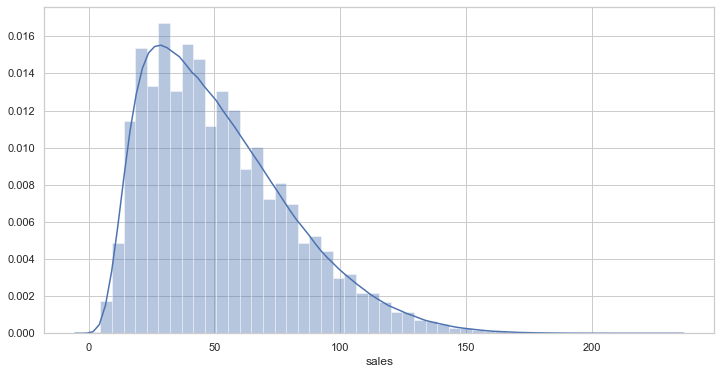

In [16]:
# plot das vendas
sns.distplot(df1['sales']);

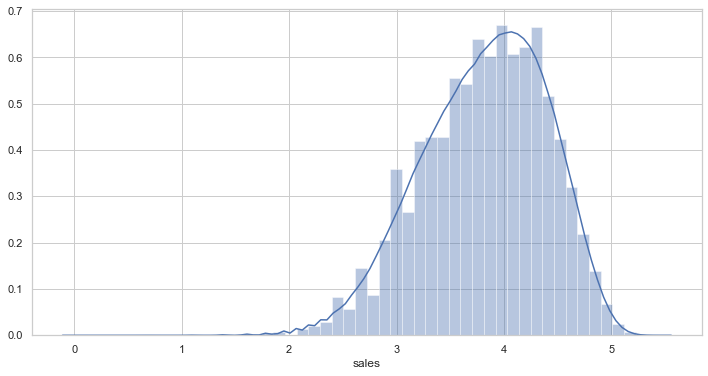

In [17]:
# plot dos logaritmos das vendas --> verificar se o log torna a distribuição das vendas mais próxima de uma normal
sns.distplot(np.log1p(df1['sales']));

# 2.0 Feature Engineering

Devido à simplicidade dos dados, e por ser exclusivamente uma Time Series, não cabe neste projeto levantar hipóteses.

Em relação à feature engineering, o óbvio a se fazer é extrair os dias, meses e ano da coluna DATE.

In [18]:
df1['day'] = df1['date'].dt.day

df1['month'] = df1['date'].dt.month

df1['year'] = df1['date'].dt.year

In [19]:
df1.sample()

,date,store,item,sales,day,month,year
106274,2014-01-02,9,6,24,2,1,2014


# 3.0 Filtragem de Variáveis

Não há variáveis a serem filtradas, exceto pela coluna Date, que foi transformada em 3 outras colunas.

In [20]:
df3 = df1.copy()

In [21]:
#df3 = df3.drop('date', axis=1)
# date vai ser usada depois para verificar se está certo a separação entre teste e treino
# vai ser usado também no cross validation de time series...

In [22]:
df3.sample()

,date,store,item,sales,day,month,year
199220,2013-07-06,10,11,91,6,7,2013


In [23]:
len(df3)

913000

In [24]:
len(df3.query('sales > 0'))

# só há um caso de um item que em certo dia em tal loja não vendeu nenhuma unidade.

912999

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
#cat_attributes = df1.select_dtypes(exclude=['int64', 'int32' 'float64', 'datetime64[ns]'])
# não há atributos categóricos neste dataset

# 4.0 Análise Exploratória de Dados

## 4.1 Análise Univariada

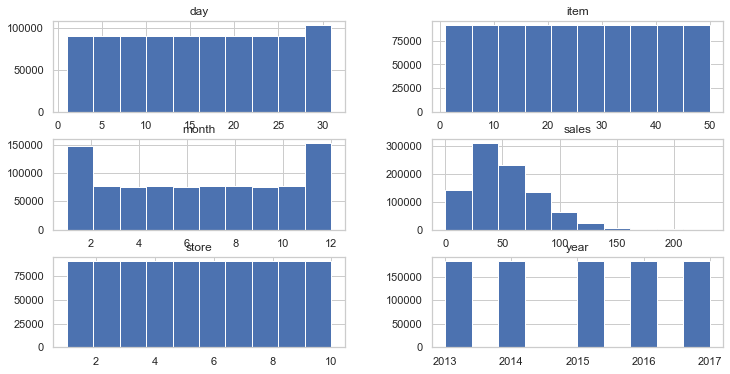

In [26]:
num_attributes.hist();

In [27]:
num_attributes.columns

Index(['store', 'item', 'sales', 'day', 'month', 'year'], dtype='object')

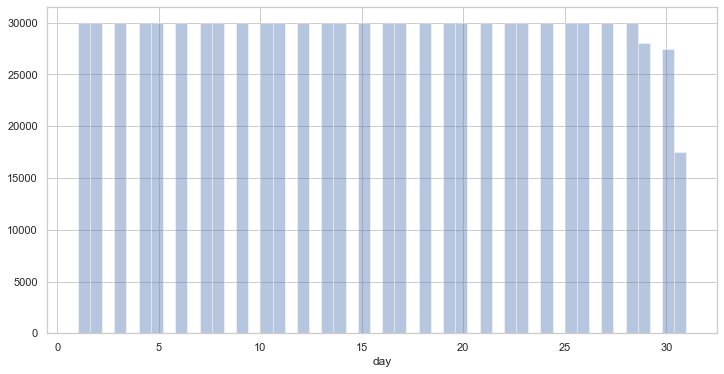

In [28]:
sns.distplot(num_attributes['day'], kde=False);

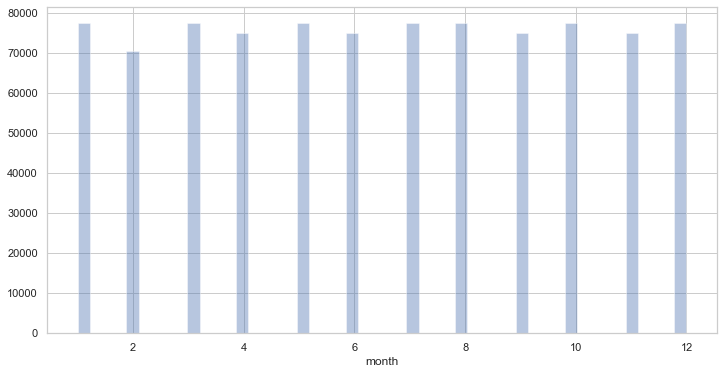

In [29]:
sns.distplot(num_attributes['month'], kde=False);

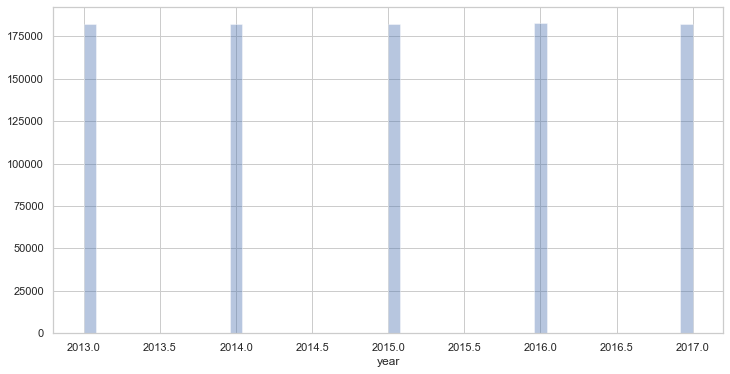

In [30]:
sns.distplot(num_attributes['year'], kde=False);

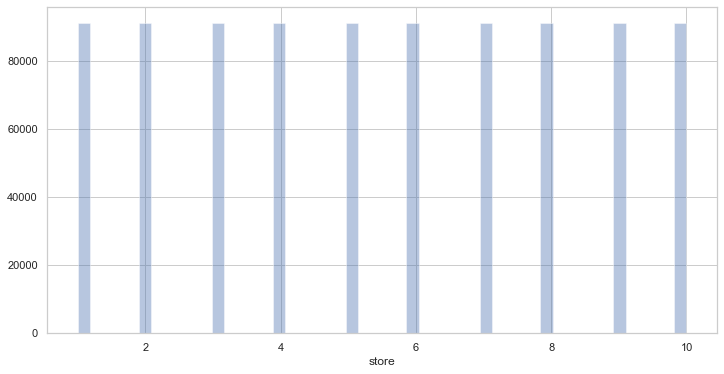

In [31]:
sns.distplot(num_attributes['store'], kde=False);

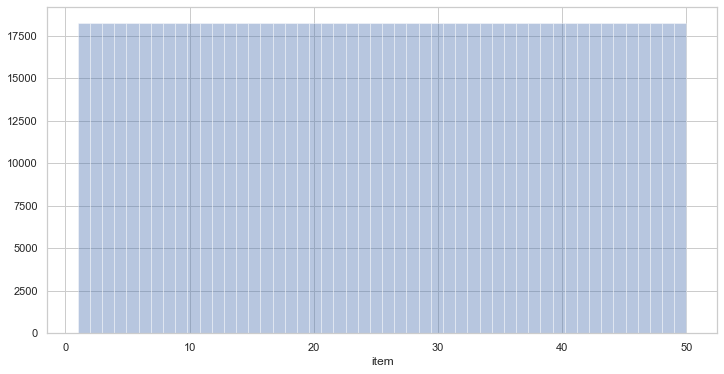

In [32]:
sns.distplot(num_attributes['item'], kde=False);

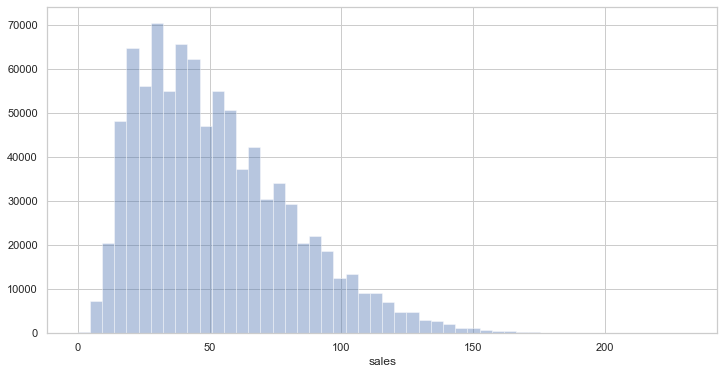

In [33]:
sns.distplot(num_attributes['sales'], kde=False);

## 4.2 Análise Bivariada

### Day vs Sales --- Não há aparente variabilidade nas compras ao longo dos dias do mês

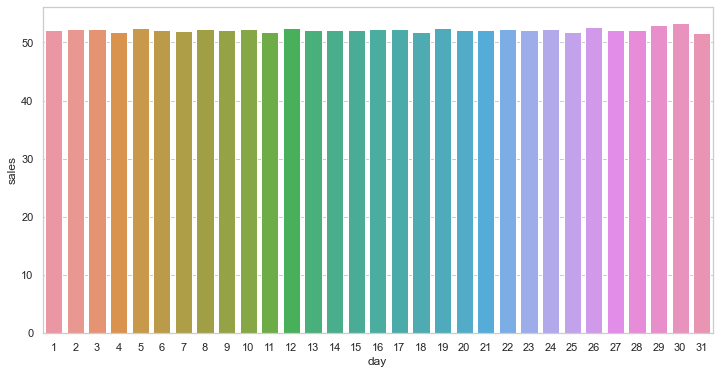

In [34]:
aux = df3[['day', 'sales']].groupby('day').mean().reset_index()

sns.barplot(data=aux, x='day', y='sales');

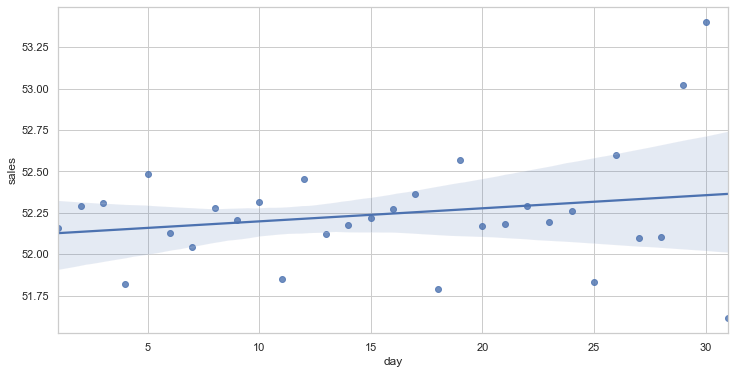

In [35]:
sns.regplot( x='day', y='sales', data=aux );

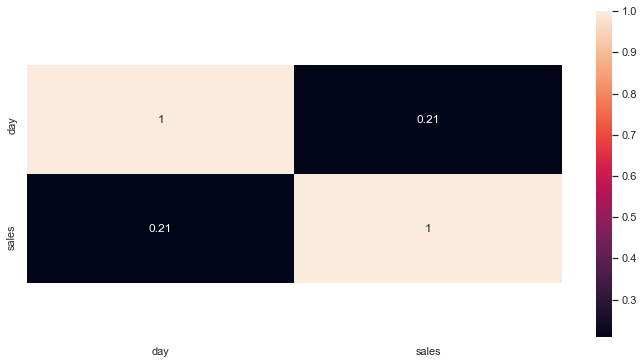

In [36]:
x = sns.heatmap( aux.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### Month vs Sales --- As vendas são maiores no segundo trimestre do ano (Maio a Agosto)

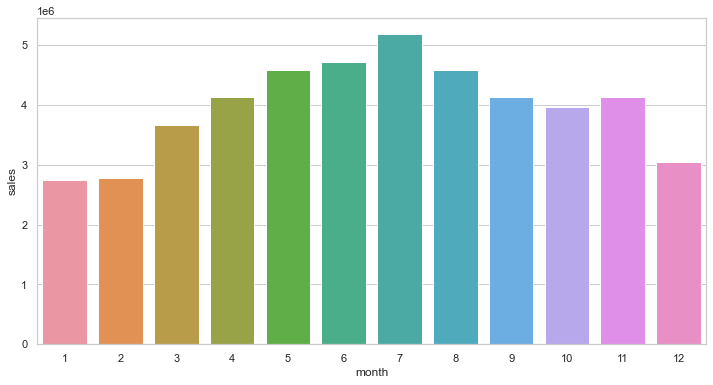

In [37]:
aux = df3[['month', 'sales']].groupby('month').sum().reset_index()

sns.barplot(data=aux, x='month', y='sales');

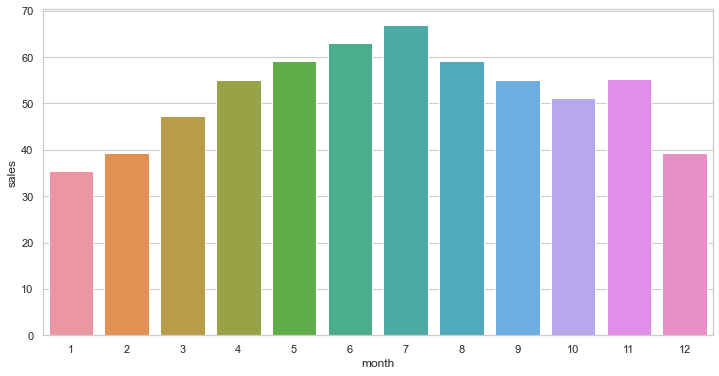

In [38]:
aux = df3[['month', 'sales']].groupby('month').mean().reset_index()

sns.barplot(data=aux, x='month', y='sales');

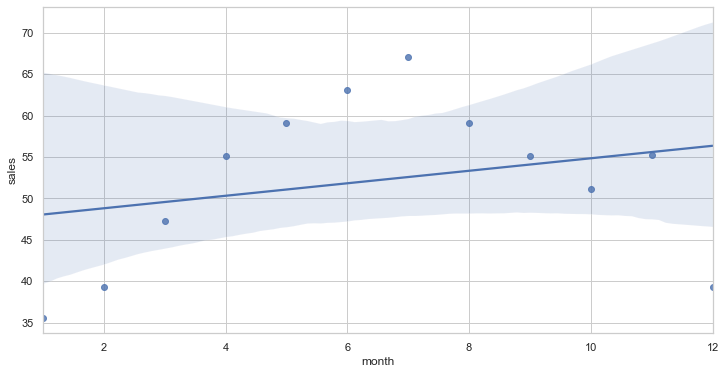

In [39]:
sns.regplot( x='month', y='sales', data=aux );

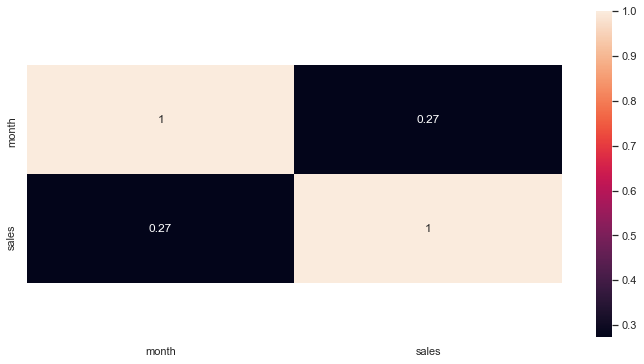

In [40]:
x = sns.heatmap( aux.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### Year vs Sales --- Há um aumento das vendas ao longo dos anos

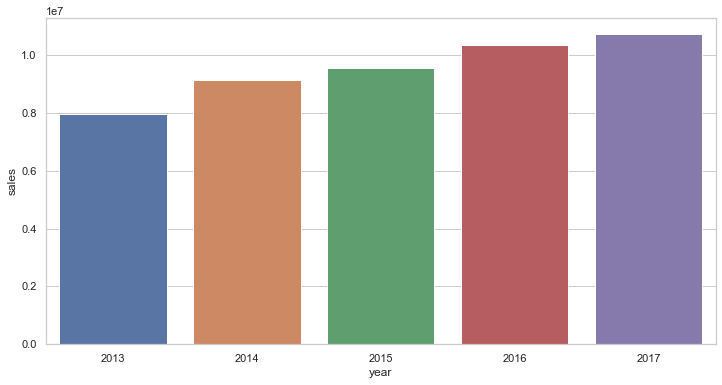

In [41]:
aux = df3[['year', 'sales']].groupby('year').sum().reset_index()

sns.barplot(data=aux, x='year', y='sales');

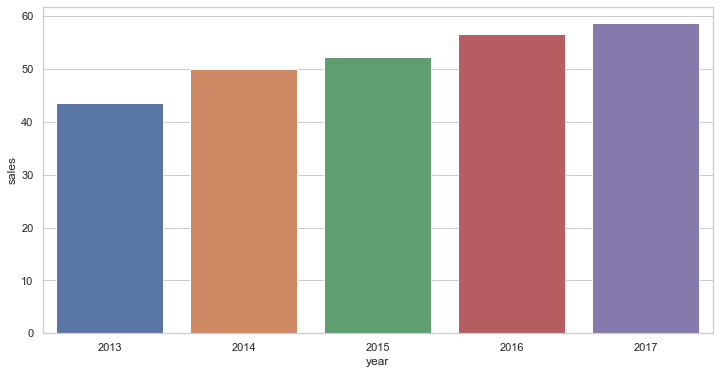

In [42]:
aux = df3[['year', 'sales']].groupby('year').mean().reset_index()

sns.barplot(data=aux, x='year', y='sales');

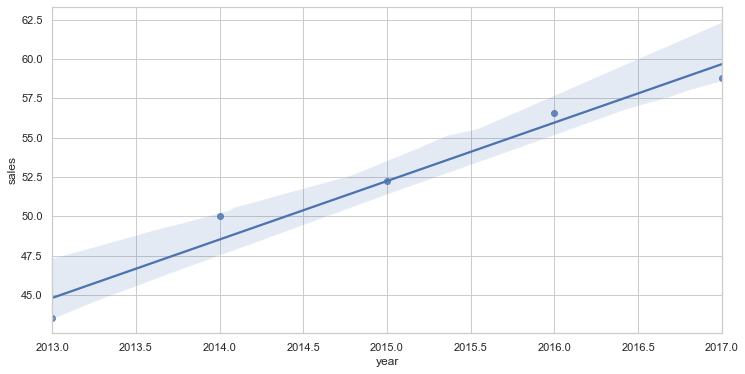

In [43]:
sns.regplot( x='year', y='sales', data=aux );

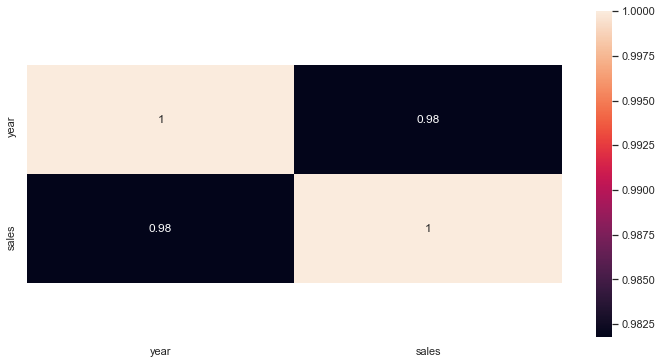

In [44]:
x = sns.heatmap( aux.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### Store --- Há três lojas que realizam menos de 40 vendas por dia, enquanto duas delas passam de 60.

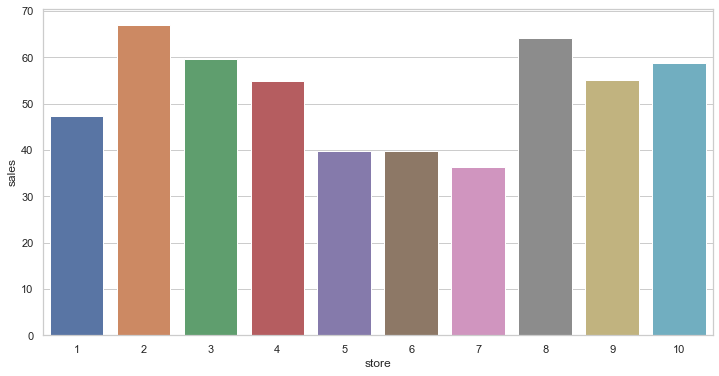

In [45]:
aux = df3[['store', 'sales']].groupby('store').mean().reset_index()

sns.barplot(data=aux, x='store', y='sales');

### Item --- Alguns itens chegam a vender 4 vezes mais do que outros

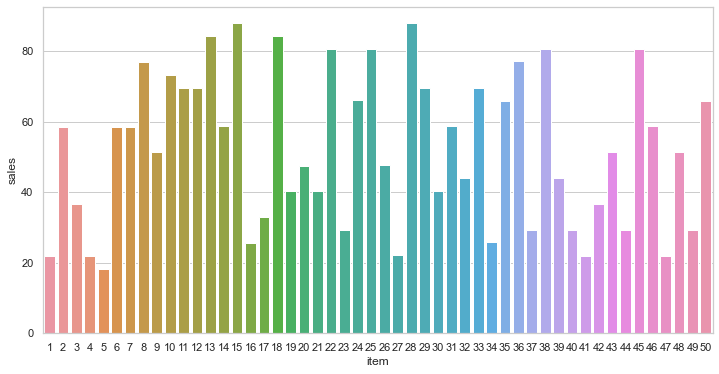

In [46]:
aux = df3[['item', 'sales']].groupby('item').mean().reset_index()

sns.barplot(data=aux, x='item', y='sales');

## 4.3 Análise Multivariada

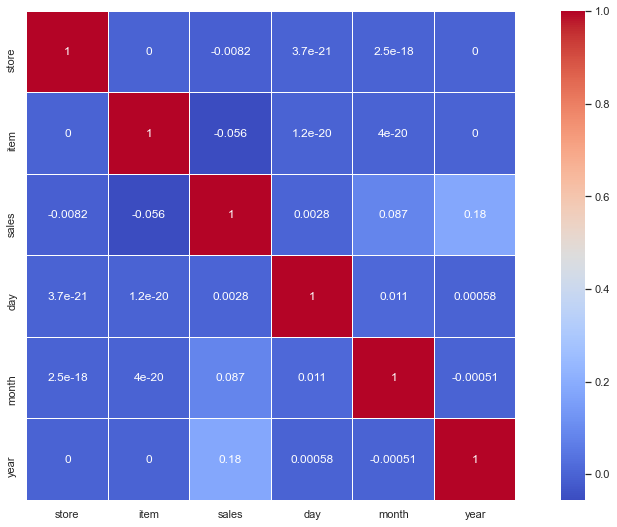

In [47]:
plt.figure(figsize=(16, 9))
sns.heatmap(data=df3.corr(),annot=True,linewidths=0.2,cmap='coolwarm', square=True);

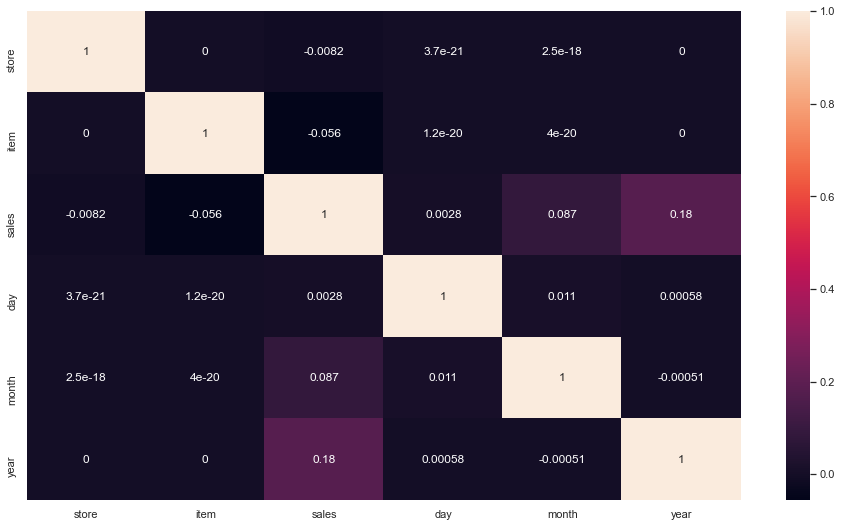

In [48]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(16, 9))
sns.heatmap(correlation, annot=True);

# 5.0 Preparação dos Dados

In [49]:
df5 = df3.copy()

In [50]:
df5.sample()

,date,store,item,sales,day,month,year
208999,2015-04-16,5,12,64,16,4,2015


## 5.1 Padronização

## 5.2 Rescaling

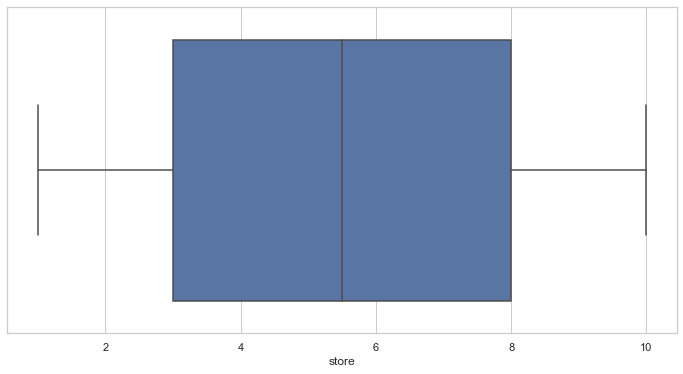

In [51]:
sns.boxplot(df5['store']);

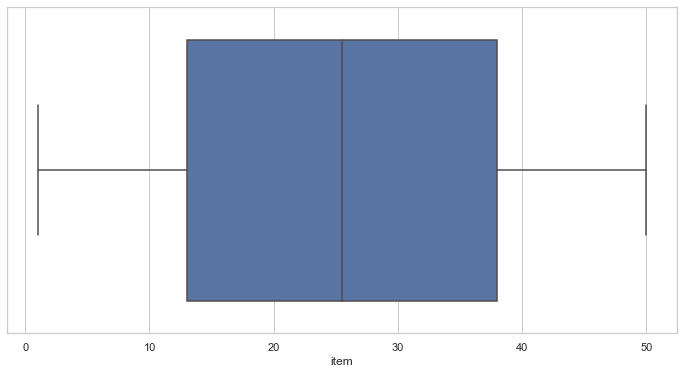

In [52]:
sns.boxplot(df5['item']);

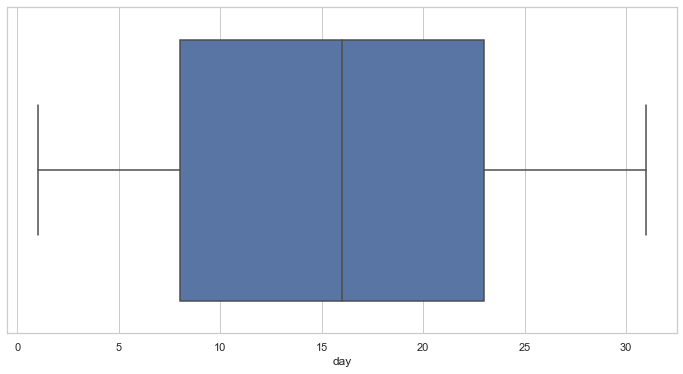

In [53]:
sns.boxplot(df5['day']);

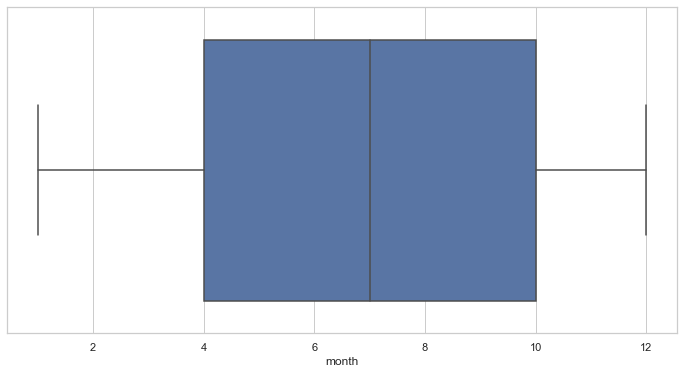

In [54]:
sns.boxplot(df5['month']);

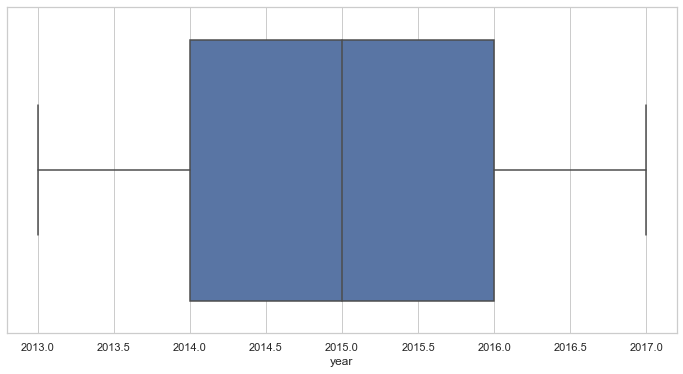

In [55]:
sns.boxplot(df5['year']);

Não há outliers nas colunas analisadas, então usarei o MinMaxScaler

In [56]:
mms = MinMaxScaler()

# competition time month
item_scaler = mms.fit( df5[['item']].values )

df5['item'] = item_scaler.transform( df5[['item']].values )

# year
year_scaler = mms.fit( df5[['year']].values)

df5['year'] = year_scaler.transform( df5[['year']].values)

## 5.3 Transformação de Variáveis

In [60]:
df5.query('item > 0 & item < 0.021').head()

,date,store,item,sales,day,month,year
18260,2013-01-01,1,0.020408,33,1,1,0.0
18261,2013-01-02,1,0.020408,43,2,1,0.0
18262,2013-01-03,1,0.020408,23,3,1,0.0
18263,2013-01-04,1,0.020408,18,4,1,0.0
18264,2013-01-05,1,0.020408,34,5,1,0.0


### 5.3.1 Encoding

### 5.3.2 Transformação da Variável Resposta

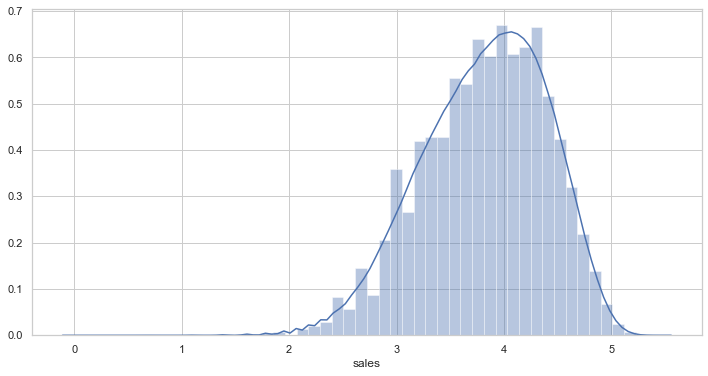

In [61]:
sns.distplot(np.log1p(df5['sales']))

TESTAR PERFORMANCE DO MODELO COM SALES NORMAL, E LOG DE SALES

### 5.3.3 Transformação Cíclica

In [62]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

In [63]:
df5.sample()

,date,store,item,sales,day,month,year,month_sin,month_cos,day_sin,day_cos
540361,2017-08-19,6,0.591837,41,19,8,1.0,-0.866025,-0.5,-0.743145,-0.669131


# 6.0 Feature Selection

Na Verdade, não temos o que selecionar aqui, é uma Time Series, precisamos do que temos, não podemos dropar nada

In [64]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and Test Dataset

In [65]:
# dropar colunas que foram transformadas em outras
cols_drop = ['day', 'month']
df6 = df6.drop(cols_drop, axis=1)

In [66]:
# removing single row with sales == 0 (can't compute MAPE with that)
i = df6[df6['sales'] == 0].index
x_time_series = df6.drop(i)
x_log_time_series = x_time_series.copy()
x_log_time_series['sales'] = np.log1p(x_log_time_series['sales'])

In [67]:
# como queremos prever as proximas 3 meses de venda, vamos usar os 3 últimos meses dos dados como teste, e o resto como treino
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=3*30)

Timestamp('2017-10-02 00:00:00')

In [68]:
X_train = df6[df6['date'] < '2017-10-02']
y_train = X_train.pop('sales')

X_test = df6[df6['date'] >= '2017-10-02']
y_test = X_test.pop('sales')

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

print('\nTamanho treino: {}'.format(X_train.shape[0]))
print('Tamanho teste: {}'.format(X_test.shape[0]))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2017-10-01 00:00:00

Test Min Date: 2017-10-02 00:00:00
Test Max Date: 2017-12-31 00:00:00

Tamanho treino: 867500
Tamanho teste: 45500


In [69]:
X_train = X_train.drop(['date'], axis=1)
X_test = X_test.drop(['date'], axis=1)

In [70]:
sum(y_train == 0)

1

In [72]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-5, random_state=42 ).fit( X_train, y_train )

In [73]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
item,0.565440
store,0.157795
month_cos,0.085126
year,0.054159
month_sin,0.047075
day_cos,0.046573
day_sin,0.043831


# 7.0 Machine Learning Modelling

## 7.1 Average Model

In [74]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction based on item
aux2 = aux1[['item', 'sales']].groupby( 'item' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='item' )  # neste caso, qualquer "how" iria dar o mesmo resultado, pois todas as stores no aux2 vao estar na aux1 também, com valores
yhat_baseline = aux1['predictions']

# performance
#baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) # exp pois as sales tinham sido transformados pra log
baseline_result = ml_error( 'Average Model',  y_test ,  yhat_baseline )  # exp pois as sales tinham sido transformados pra log
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,13.438902,1.188148,17.602783


In [75]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction based on store
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )  
yhat_baseline = aux1['predictions']

# performance
#baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) 
baseline_result = ml_error( 'Average Model',  y_test ,  yhat_baseline )  # exp pois as sales tinham sido transformados pra log
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,21.533896,0.977643,26.280034


In [77]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

## 7.2 Linear Regression Model

In [78]:
# model
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression',  y_test ,  yhat_lr  )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,22.624577,0.599991,28.017201


### 7.2.1. Linear Regression Model - Cross Validation

In [79]:
lr_result_cv = time_series_cross_validation( x_time_series, 5, 3*30, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,23.52 +/- 0.67,0.61 +/- 0.07,29.22 +/- 0.65


In [80]:
lr_result_cv_log = log_time_series_cross_validation( x_log_time_series, 5, 3*30, 'Linear Regression', lr, verbose=False )
lr_result_cv_log

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,23.55 +/- 0.47,0.54 +/- 0.06,30.11 +/- 1.27


In [81]:
# algoritmo de Meigarom
lr_result_cv_ = cross_validation( x_time_series, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv_

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,23.89 +/- 3.03,0.62 +/- 0.04,29.21 +/- 3.63


## 7.3 Linear Regression Regularized Model - Lasso

In [82]:
# model
lrr = Lasso( alpha=0.001 ).fit( X_train, y_train )

# prediction
yhat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test ,  yhat_lrr  )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,22.624424,0.599942,28.017449


### 7.3.1. Lasso - Cross Validation

In [83]:
lrr_result_cv = time_series_cross_validation( x_time_series, 5, 3*30, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,23.52 +/- 0.67,0.61 +/- 0.07,29.22 +/- 0.65


In [84]:
lrr_result_cv_log = log_time_series_cross_validation( x_log_time_series, 5, 3*30, 'Lasso', lrr, verbose=False )
lrr_result_cv_log

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,23.49 +/- 0.52,0.53 +/- 0.04,30.12 +/- 1.32


In [86]:
# algoritmo de Meigarom
lrr_result_cv_ = cross_validation( x_time_series, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv_

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,23.89 +/- 3.03,0.62 +/- 0.04,29.21 +/- 3.63


## 7.4 Random Forest Model

In [87]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-5, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', y_test , yhat_rf  )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,9.273987,0.197535,12.480432


### 7.4.1. Random Forest Regressor - Cross Validation

In [89]:
rf_result_cv = time_series_cross_validation( x_time_series, 5, 3*30, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,11.04 +/- 1.43,0.21 +/- 0.02,14.77 +/- 1.99


In [90]:
rf_result_cv_log = log_time_series_cross_validation( x_log_time_series, 5, 3*30, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv_log


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,11.28 +/- 1.44,0.21 +/- 0.02,15.03 +/- 2.02


In [91]:
# algoritmo de Meigarom
rf_result_cv_ = cross_validation( x_time_series, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv_


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,9.68 +/- 0.86,0.19 +/- 0.01,12.88 +/- 1.15


## 7.5 XGBoost Regressor

In [92]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=300,
                              n_jobs=-5,
                              eta=0.01, 
                              max_depth=15, 
                              subsample=0.7,
                              colsample_bytee=0.9).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor',  y_test ,  yhat_xgb  )
xgb_result

[10:42:31] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,9.214484,0.181493,12.3087


### 7.5.1. XGBoost Regressor - Cross Validation

In [93]:
xgb_result_cv = time_series_cross_validation( x_time_series, 5, 3*30, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 1
[10:46:08] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 2
[10:48:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[10:49:35] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,11.44 +/- 1.68,0.2 +/- 0.02,15.48 +/- 2.27


In [94]:
xgb_result_cv_log = log_time_series_cross_validation( x_log_time_series, 5, 3*30, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv_log


KFold Number: 1
[10:59:56] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 2
[11:01:20] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[11:02:12] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,16.39 +/- 1.69,0.27 +/- 0.03,21.79 +/- 2.04


In [95]:
# algoritmo de Meigarom
xgb_result_cv_ = cross_validation( x_time_series, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv_


KFold Number: 5
[11:08:36] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[11:10:09] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[11:11:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,9.92 +/- 0.97,0.18 +/- 0.01,13.25 +/- 1.25


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [134]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.to_pickle('modelling_result.pkl')
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,9.214484,0.181493,12.308700
0,Random Forest Regressor,9.273987,0.197535,12.480432
0,Average Model,21.533896,0.977643,26.280034
0,Linear Regression,22.624577,0.599991,28.017201
0,Linear Regression - Lasso,22.624424,0.599942,28.017449


### 7.6.2. Real Performance - Cross Validation

In [133]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] ) 
modelling_result_cv.to_pickle('modelling_result_cv.pkl')
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,11.04 +/- 1.43,0.21 +/- 0.02,14.77 +/- 1.99
0,XGBoost Regressor,11.44 +/- 1.68,0.2 +/- 0.02,15.48 +/- 2.27
0,Linear Regression,23.52 +/- 0.67,0.61 +/- 0.07,29.22 +/- 0.65
0,Lasso,23.52 +/- 0.67,0.61 +/- 0.07,29.22 +/- 0.65


### Cross Validation with Log

In [132]:
modelling_result_cv_log = pd.concat( [lr_result_cv_log, lrr_result_cv_log, rf_result_cv_log, xgb_result_cv_log] ) 
modelling_result_cv_log.to_pickle('modelling_result_cv_log.pkl')
modelling_result_cv_log.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,11.28 +/- 1.44,0.21 +/- 0.02,15.03 +/- 2.02
0,XGBoost Regressor,16.39 +/- 1.69,0.27 +/- 0.03,21.79 +/- 2.04
0,Linear Regression,23.55 +/- 0.47,0.54 +/- 0.06,30.11 +/- 1.27
0,Lasso,23.49 +/- 0.52,0.53 +/- 0.04,30.12 +/- 1.32


### Cross Validation Time Series com Meigarom Code

In [131]:
# algoritmo de Meigarom
modelling_result_cv_meigarom = pd.concat( [lr_result_cv_, lrr_result_cv_, rf_result_cv_, xgb_result_cv_] ) 
modelling_result_cv_meigarom.to_pickle('modelling_result_cv_meigarom.pkl')
modelling_result_cv_meigarom.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,9.68 +/- 0.86,0.19 +/- 0.01,12.88 +/- 1.15
0,XGBoost Regressor,9.92 +/- 0.97,0.18 +/- 0.01,13.25 +/- 1.25
0,Linear Regression,23.89 +/- 3.03,0.62 +/- 0.04,29.21 +/- 3.63
0,Lasso,23.89 +/- 3.03,0.62 +/- 0.04,29.21 +/- 3.63


# 8.0 Hyperparameter Fine Tuning

In [100]:
param = {
   'n_estimators': [300],
   'eta': [0.01, 0.03],
   'max_depth': [5, 9, 12],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

## 8.1 Random Search

In [101]:
# random_search = RandomizedSearchCV(
#     estimator=model_xgb,
#     param_distributions=param,
#     n_iter=30,
#     n_jobs=-5,
#     cv=5,
#     random_state=0
# )

# search = random_search.fit(X_train, y_train)
# search.best_params_

## 8.2 Bayesian Search

In [102]:
# bayes_search = BayesSearchCV(
#     estimator=model_xgb,
#     search_spaces=param,
#     n_jobs=-5,
#     n_iter=30,
#     random_state=0,
#     cv=5
#  )
# bayes_search.fit(X_train, y_train)
# bayes_search.score(X_test, y_test)

# tá dando erro, sabe-se lá pq: TypeError: object.__init__() takes exactly one argument (the instance to initialize)

## 8.3 Final Model

In [103]:
param_tuned = {
 'subsample': 0.1,
 'n_estimators': 300,
 'min_child_weight': 15,
 'max_depth': 5,
 'eta': 0.03,
 'colsample_bytree': 0.3}

In [104]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( X_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor',  y_test,  yhat_xgb_tuned )
xgb_result_tuned

[11:17:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,10.314428,0.230505,13.696915


In [105]:
mpe = mean_percentage_error( y_test , yhat_xgb_tuned )
mpe  # o modelo está subestimando as sales

-0.09794320166110992

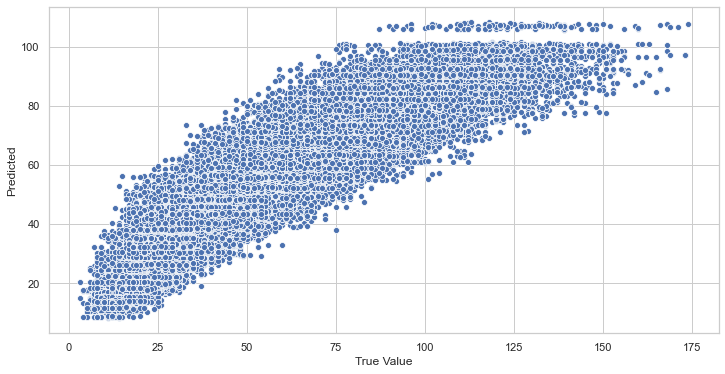

In [106]:
# real x predito
sns.scatterplot(x= y_test, y= yhat_xgb_tuned );
plt.xlabel('True Value');
plt.ylabel('Predicted');

In [107]:
#          Model Name	     MAE	   MAPE	       RMSE              MPE
# 0	XGBoost Regressor	10.314428	0.230505	13.696915   -0.09794320166110992

# 9.0 Tradução e Interpretação do Erro

In [108]:
df9 = X_test.copy()

df9.loc[:, 'sales'] =  y_test
df9.loc[:, 'predictions'] = yhat_xgb_tuned
df9.loc[:, 'date'] = df6.loc[df9.index]

In [112]:
df9.to_csv('D:\df9.csv')

## 9.1 Business Performacne

In [113]:
# O quanto de receita vai entrar no meu modelo?
df9_sum = df9[['store', 'predictions']].groupby('store').sum().reset_index()
df9_mean = df9[['store', 'predictions']].groupby('store').mean().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_aux4 = pd.merge(df9_mean, df9_aux3, how='inner', on='store')
df92 = pd.merge(df9_sum, df9_aux4, how='inner', on='store').rename(columns={'predictions_x': 'sum_predictions', 'predictions_y': 'mean_predictions'})

# Scenarios
df92['daily_worst_scenario'] = df92['mean_predictions'] - df92['MAE']
df92['daily_best_scenario'] = df92['mean_predictions'] + df92['MAE']

df92['3_month_worst_scenario'] = df92['sum_predictions'] - df92['MAPE'] * df92['sum_predictions']
df92['3_month_best_scenario'] = df92['sum_predictions'] + df92['MAPE'] * df92['sum_predictions']
# sum predictions é a soma das vendas previstas para os próximos 3 meses de cada loja

In [114]:
df92.head()

,store,sum_predictions,mean_predictions,MAE,MAPE,daily_worst_scenario,daily_best_scenario,3_month_worst_scenario,3_month_best_scenario
0,1,226656.265625,49.814564,8.834273,0.222349,40.980291,58.648836,176259.394510,277053.136740
1,2,303020.406250,66.597893,14.118780,0.234568,52.479113,80.716673,231941.488618,374099.323882
2,3,278605.718750,61.232029,11.975870,0.236292,49.256159,73.207899,212773.444123,344437.993377
3,4,257885.593750,56.678154,10.926060,0.236771,45.752094,67.604214,196825.667774,318945.519726
4,5,193174.390625,42.455910,7.572048,0.229848,34.883862,50.027958,148773.564931,237575.216319


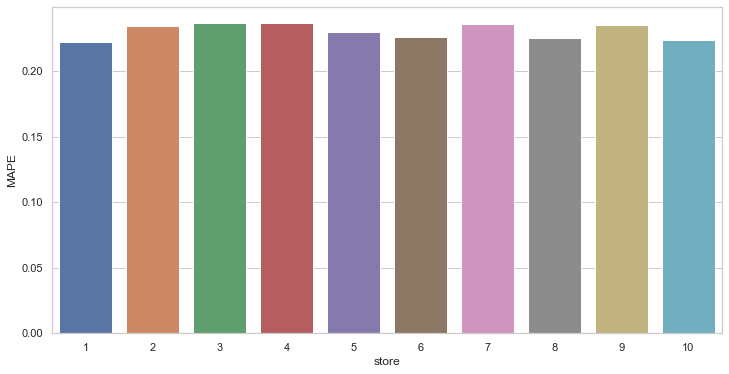

In [115]:
sns.barplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [116]:
df93 = df92[['sum_predictions', '3_month_worst_scenario', '3_month_best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,sum_predictions,"R$ 2,458,941.78"
1,3_month_worst_scenario,"R$ 1,891,946.09"
2,3_month_best_scenario,"R$ 3,025,937.47"


## 9.3 Machine Learning Performance

In [117]:
df9.loc[:, 'error'] = df9.loc[:, 'sales'] - df9.loc[:, 'predictions']
df9.loc[:, 'error_rate'] = df9.loc[:, 'predictions'] / df9.loc[:, 'sales']

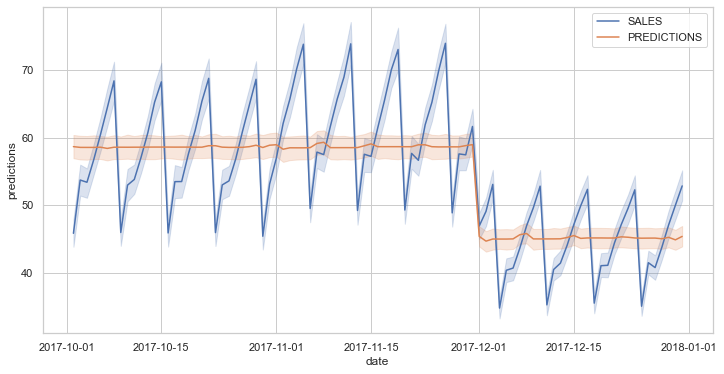

In [118]:
# By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate.
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

PORQUE TEM ESSAS QUEDAS NAS VENDAS?
E PORQUE AS VENDAS SÃO TÃO CÍCLICAS?

VERIFICAR DEPOIS O GRÁFICO FEITO NO ROSSMANN

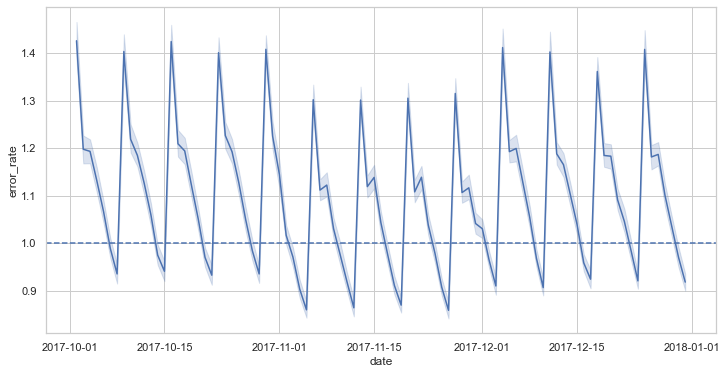

In [119]:
sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline( 1, linestyle='--');

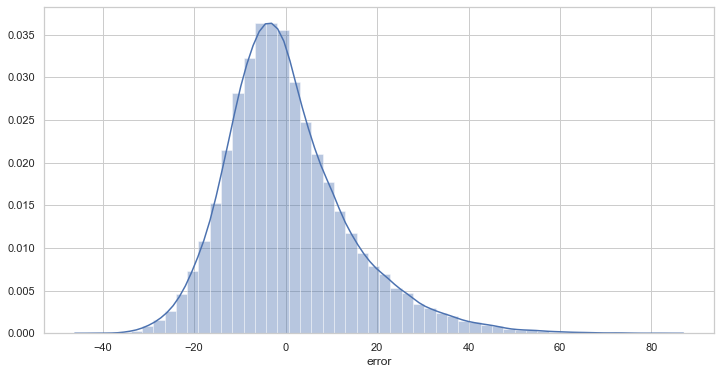

In [120]:
sns.distplot( df9['error'] );

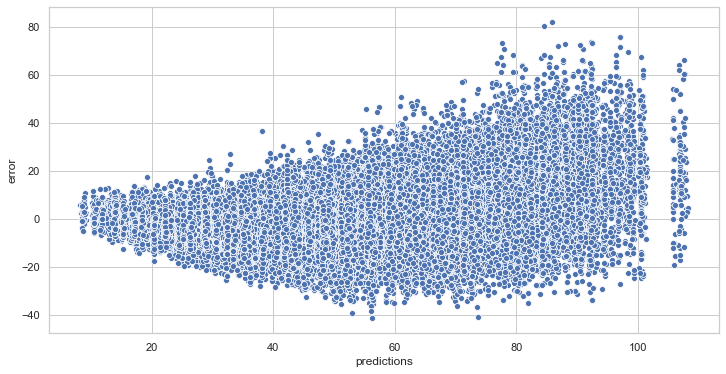

In [121]:
sns.scatterplot( df9['predictions'], df9['error'] );
# o erro aumenta com o tamanho das predições